In [6]:
#profiler load 
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../..')
from pyprofiler.utils import config_utils
import pyprofiler.utils.goatools_utils as goa
import pyprofiler.profiler as profiler
from qtlsearch.OBOParser import OBO
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
#select rand profile w annotations
#mask annotations
#pull in coevolving Hogs
#feed profile vectors and GO to NN
#Try to recover annotations

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
#lets also create a go annotation enrichment study object to describe functional enrichment in our profiling results

gaf = goa.buildGAF( '/home/cactuskid13/mntpt/OMA/latest/oma-go.txt' )

In [54]:
#load oma hogs to prot sequence mapping

import gzip
import pickle
with gzip.open('oma-hogs-Jun2019.p.gz', 'rb') as fp:
    hogs = pickle.load(fp)
print(list(hogs.keys())[0:10])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [24]:
from goatools import obo_parser
obo = './go.obo'
obo = obo_parser.GODag(obo)

./go.obo: fmt(1.2) rel(2019-12-09) 47,311 GO Terms


In [ ]:
p = profiler.Profiler(lshforestpath = config_utils.datadir + '/latest_all_256/newlshforest.pkl'  , hashes_h5=config_utils.datadir+ 'latest_all_256/hashes.h5'  , mat_path= None, oma = '/home/cactuskid13/mntpt/OMA/latest/OmaServer.h5', tar= None , mastertree =config_utils.datadir + 'latest_all_256_master_tree.pkl' , nsamples = 256)

In [1]:
ls ../../all/all/



errors.txt                           latest_fungi_256/
latest_all_256/                      latest_fungi_256_master_tree.nwk
latest_all_256_master_tree.nwk       latest_fungi_256_master_tree.pkl
latest_all_256_master_tree.pkl       latest_metazoa_256/
latest_archaea_256/                  latest_metazoa_256_master_tree.nwk
latest_archaea_256_master_tree.nwk   latest_metazoa_256_master_tree.pkl
latest_archaea_256_master_tree.pkl   latest_plants_256/
latest_bacteria_256/                 latest_plants_256_master_tree.nwk
latest_bacteria_256_master_tree.nwk  latest_plants_256_master_tree.pkl
latest_bacteria_256_master_tree.pkl  latest_vertebrates_256/
latest_eukarya_256/                  latest_vertebrates_256_master_tree.nwk
latest_eukarya_256_master_tree.nwk   latest_vertebrates_256_master_tree.pkl
latest_eukarya_256_master_tree.pkl   taxaIndex.pkl


In [14]:
import glob
profilers = glob.glob('../../all/all/*/*forest.pkl')
hashes = glob.glob('../../all/all/*/*h5')

dbs = list(zip (profilers,hashes))
print(dbs)
exclude = ['archaea']
profilers = {}
for p,h in dbs:
    ptype = p.split('/')[4].split('_')[1]
    if ptype not in exclude:
        print(ptype)

        profilers[ptype] = profiler.Profiler(lshforestpath = p  , hashes_h5= h  , mat_path= None,
            oma = '/home/cactuskid13/mntpt/OMA/latest/OmaServer.h5', tar= None , mastertree =config_utils.datadir + 'latest_all_256_master_tree.pkl' , nsamples = 256)
        

[('../../all/all/latest_fungi_256/newlshforest.pkl', '../../all/all/latest_fungi_256/hashes.h5'), ('../../all/all/latest_vertebrates_256/newlshforest.pkl', '../../all/all/latest_vertebrates_256/hashes.h5'), ('../../all/all/latest_all_256/newlshforest.pkl', '../../all/all/latest_all_256/hashes.h5'), ('../../all/all/latest_plants_256/newlshforest.pkl', '../../all/all/latest_plants_256/hashes.h5'), ('../../all/all/latest_bacteria_256/newlshforest.pkl', '../../all/all/latest_bacteria_256/hashes.h5'), ('../../all/all/latest_eukarya_256/newlshforest.pkl', '../../all/all/latest_eukarya_256/hashes.h5'), ('../../all/all/latest_archaea_256/newlshforest.pkl', '../../all/all/latest_archaea_256/hashes.h5'), ('../../all/all/latest_metazoa_256/newlshforest.pkl', '../../all/all/latest_metazoa_256/hashes.h5')]
fungi
loading lsh
indexing lsh


Cannot load SequenceSearch. Any future call to seq_search will fail!
Traceback (most recent call last):
  File "../../../pyprofiler/pyoma/browser/db.py", line 879, in __init__
    self.seq_idx = self.seq_idx()
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/link.py", line 397, in __call__
    self.extfile = tables.open_file(filename, **kwargs)
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/file.py", line 320, in open_file
    return File(filename, mode, title, root_uep, filters, **kwargs)
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/file.py", line 784, in __init__
    self._g_new(filename, mode, **params)
  File "tables/hdf5extension.pyx", line 374, in tables.hdf5extension.File._g_new
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/utils.py", line 157, in check_file_access
    raise IOError("``%s`` does not exist" % (fil

3278
DONE
vertebrates
loading lsh
indexing lsh


Cannot load SequenceSearch. Any future call to seq_search will fail!
Traceback (most recent call last):
  File "../../../pyprofiler/pyoma/browser/db.py", line 879, in __init__
    self.seq_idx = self.seq_idx()
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/link.py", line 397, in __call__
    self.extfile = tables.open_file(filename, **kwargs)
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/file.py", line 320, in open_file
    return File(filename, mode, title, root_uep, filters, **kwargs)
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/file.py", line 784, in __init__
    self._g_new(filename, mode, **params)
  File "tables/hdf5extension.pyx", line 374, in tables.hdf5extension.File._g_new
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/utils.py", line 157, in check_file_access
    raise IOError("``%s`` does not exist" % (fil

3278
DONE
all
loading lsh
indexing lsh


Cannot load SequenceSearch. Any future call to seq_search will fail!
Traceback (most recent call last):
  File "../../../pyprofiler/pyoma/browser/db.py", line 879, in __init__
    self.seq_idx = self.seq_idx()
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/link.py", line 397, in __call__
    self.extfile = tables.open_file(filename, **kwargs)
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/file.py", line 320, in open_file
    return File(filename, mode, title, root_uep, filters, **kwargs)
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/file.py", line 784, in __init__
    self._g_new(filename, mode, **params)
  File "tables/hdf5extension.pyx", line 374, in tables.hdf5extension.File._g_new
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/utils.py", line 157, in check_file_access
    raise IOError("``%s`` does not exist" % (fil

3278
DONE
plants
loading lsh
indexing lsh


Cannot load SequenceSearch. Any future call to seq_search will fail!
Traceback (most recent call last):
  File "../../../pyprofiler/pyoma/browser/db.py", line 879, in __init__
    self.seq_idx = self.seq_idx()
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/link.py", line 397, in __call__
    self.extfile = tables.open_file(filename, **kwargs)
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/file.py", line 320, in open_file
    return File(filename, mode, title, root_uep, filters, **kwargs)
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/file.py", line 784, in __init__
    self._g_new(filename, mode, **params)
  File "tables/hdf5extension.pyx", line 374, in tables.hdf5extension.File._g_new
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/utils.py", line 157, in check_file_access
    raise IOError("``%s`` does not exist" % (fil

3278
DONE
bacteria
loading lsh
indexing lsh


Cannot load SequenceSearch. Any future call to seq_search will fail!
Traceback (most recent call last):
  File "../../../pyprofiler/pyoma/browser/db.py", line 879, in __init__
    self.seq_idx = self.seq_idx()
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/link.py", line 397, in __call__
    self.extfile = tables.open_file(filename, **kwargs)
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/file.py", line 320, in open_file
    return File(filename, mode, title, root_uep, filters, **kwargs)
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/file.py", line 784, in __init__
    self._g_new(filename, mode, **params)
  File "tables/hdf5extension.pyx", line 374, in tables.hdf5extension.File._g_new
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/utils.py", line 157, in check_file_access
    raise IOError("``%s`` does not exist" % (fil

3278
DONE
eukarya
loading lsh
indexing lsh


Cannot load SequenceSearch. Any future call to seq_search will fail!
Traceback (most recent call last):
  File "../../../pyprofiler/pyoma/browser/db.py", line 879, in __init__
    self.seq_idx = self.seq_idx()
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/link.py", line 397, in __call__
    self.extfile = tables.open_file(filename, **kwargs)
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/file.py", line 320, in open_file
    return File(filename, mode, title, root_uep, filters, **kwargs)
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/file.py", line 784, in __init__
    self._g_new(filename, mode, **params)
  File "tables/hdf5extension.pyx", line 374, in tables.hdf5extension.File._g_new
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/utils.py", line 157, in check_file_access
    raise IOError("``%s`` does not exist" % (fil

3278
DONE
metazoa
loading lsh
indexing lsh


Cannot load SequenceSearch. Any future call to seq_search will fail!
Traceback (most recent call last):
  File "../../../pyprofiler/pyoma/browser/db.py", line 879, in __init__
    self.seq_idx = self.seq_idx()
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/link.py", line 397, in __call__
    self.extfile = tables.open_file(filename, **kwargs)
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/file.py", line 320, in open_file
    return File(filename, mode, title, root_uep, filters, **kwargs)
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/file.py", line 784, in __init__
    self._g_new(filename, mode, **params)
  File "tables/hdf5extension.pyx", line 374, in tables.hdf5extension.File._g_new
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/utils.py", line 157, in check_file_access
    raise IOError("``%s`` does not exist" % (fil

3278
DONE


In [21]:
#generate tx filters

def clip_tree(newtree , taxfilter , taxmask):
    for n in newtree.traverse():
            if taxmask:
                if str(n.name) == str(taxmask):
                    newtree = n
                    break
            if taxfilter:
                if n.name in taxfilter:
                    n.delete()
    return {n.name for n in newtree.get_leaves()}

dbdict = {
    'all': { 'taxfilter': None , 'taxmask': None },
    'plants': { 'taxfilter': None , 'taxmask': 33090 },
    'archaea':{ 'taxfilter': None , 'taxmask': 2157 },
    'bacteria':{ 'taxfilter': None , 'taxmask': 2 },
    'eukarya':{ 'taxfilter': None , 'taxmask': 2759 },
    'protists':{ 'taxfilter': [2 , 2157 , 33090 , 4751, 33208] , 'taxmask':None },
    'fungi':{ 'taxfilter': None , 'taxmask': 4751 },
    'metazoa':{ 'taxfilter': None , 'taxmask': 33208 },
    'vertebrates':{ 'taxfilter': None , 'taxmask': 7742 },
    }

#only keep leaves as extant genomes allowed for each profiler

taxfilters ={}
import pickle
for ptype in profilers:
    print(ptype)
    taxfilters[ptype] = clip_tree( profilers[ptype].tree , dbdict[ptype][ 'taxfilter'],  dbdict[ptype][ 'taxmask'] )
    print(len(taxfilters[ptype]))

with open('taxfilters.pkl' , 'wb' ) as filterout:
    filterout.write(pickle.dumps(taxfilters))

fungi
136
vertebrates
100
all
2290
plants
57
bacteria
1674
eukarya
463
metazoa
188


In [95]:

species = pd.read_table( './oma-species.txt' , sep = '\t' , comment = '#', header = None)
specdict = dict( zip(species[0] , species[1]) )


/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


In [7]:

for i in range(5):
    t0 = time.time()
    next(hogiterator)
    print( time.time()-t0)

print( next(hogiterator).head() )

0.3011929988861084
0.05627608299255371
0.29827451705932617
0.05711483955383301
0.0658414363861084
           genome                                 annot   hog  taxcode
CALMQ00997  CALMQ  {GO:0000150, GO:0006310, GO:0003677}  3223   397948
PYRAE02475  PYRAE  {GO:0000150, GO:0006310, GO:0003677}  3223   178306
PYRAR01890  PYRAR  {GO:0000150, GO:0006310, GO:0003677}  3223   340102
PYRCJ01941  PYRCJ  {GO:0000150, GO:0006310, GO:0003677}  3223   410359
PYRIL00788  PYRIL  {GO:0000150, GO:0006310, GO:0003677}  3223   384616


In [7]:
targets = pd.read_table( './out_map_by_hog.tsv')
targets = targets.sort_values( by= 'oma_id')
targets['species'] = targets.oma_id.map( lambda x : x[0:5])
print(targets.head())
targets['taxcode'] = targets.species.map(specdict)
print(targets.head())


/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


            cafa_id      oma_id     fam species
57070  T37020001074  ARATH00006  472976   ARATH
69814  T37020003425  ARATH00010  483443   ARATH
70000  T37020007063  ARATH00011  483592   ARATH
3798   T37020007582  ARATH00013  182502   ARATH
3236   T37020015139  ARATH00015  177269   ARATH
            cafa_id      oma_id     fam species  taxcode
57070  T37020001074  ARATH00006  472976   ARATH     3702
69814  T37020003425  ARATH00010  483443   ARATH     3702
70000  T37020007063  ARATH00011  483592   ARATH     3702
3798   T37020007582  ARATH00013  182502   ARATH     3702
3236   T37020015139  ARATH00015  177269   ARATH     3702


In [46]:
def fam2hogid(fam_id):
    """
    For use with OMA HOGs
    Get hog id given fam
    :param fam_id: fam
    :return: hog id
    """
    hog_id = "HOG:" + (7-len(str(fam_id))) * '0' + str(fam_id)
    return hog_id

def hogid2fam(hog_id):
    """
    For use with OMA HOGs
    Get hog id given fam
    :param fam_id: fam
    :return: hog id
    """
    fam_id = int(hog_id.split(':')[1])
    return fam_id

def id2GO(intID):
    return 'GO:{:07d}'.format(intID)


def id2GO(intID):
    return 'GO:{:07d}'.format(intID)

def go2id(strID):
    if type( strID) is int:
        return strID
    return int(strID.split(':')[1])



def get_ancestors( golist , obo,  levels = 4 ):
    ancestors = []
    
    for l in range( levels):
        try:
            if l == 0 :
                a = [ obo[p.id].id for g in golist for p in obo[g].parents if g in obo and p.id in obo ]
            else:
                a = [ obo[p.id].id for g in a for p in obo[g].parents if g in obo and p.id in obo ]
            ancestors += a
        except:
            pass
    ancestors += golist
    return [goa.goterm2id(goterm) for goterm in set(ancestors)]

def get_ancestors_all( golist , obo):
    ancestors = []
    lastlen = -1
    l = 0
    while len(ancestors)>lastlen:
        if l == 0 :
            a = [ obo[p.id].id for g in golist for p in obo[g].parents if g in obo and p.id in obo]
            
        else:
            a = [ obo[p.id].id for g in a for p in obo[g].parents if g in obo and p.id in obo ]
        lastlen = len(ancestors)
        ancestors += a
        l+=1
    
    ancestors += golist
    return [goa.goterm2id(goterm) for goterm in set(ancestors)]

In [11]:
qhog = '479378'
res = p.hog_query(fam_id=int(qhog) , k = 100)
res +=['479378']

#res =[ "HOG:" + (7-len(str(fam_id))) * '0' + str(fam_id) for fam_id in res ]
godict = { r:  { m:gaf[m]  for m in hogs[int(r)] if m in gaf} for r in res}
print(godict['479378'])
godict = { r: get_ancestors ( set([ g  for go in godict[r].values() for g in go] ) , obo ) for r in godict }
hashes =  p.pull_hashes(res)
jaccards = { r:hashes[r].jaccard(hashes[qhog]) for r in hashes }


{'PHAAN05400': {'GO:0007338', 'GO:0005783', 'GO:0005886', 'GO:0016021', 'GO:0016020', 'GO:0008289'}, 'WHEAT81026': {'GO:0016020', 'GO:0016021'}, 'ARALY23176': {'GO:0016021'}, 'WHEAT87894': {'GO:0007338', 'GO:0005783', 'GO:0005886', 'GO:0016021', 'GO:0016020', 'GO:0008289'}, 'SOYBN42891': {'GO:0007338', 'GO:0005783', 'GO:0005886', 'GO:0016021', 'GO:0008289'}, 'LEIIN00285': {'GO:0016020', 'GO:0016021'}, 'ORYNI37447': {'GO:0016021'}, 'GOSRA46123': {'GO:0048235', 'GO:0007338', 'GO:0005783', 'GO:0061936', 'GO:0005886', 'GO:0016021', 'GO:0005887', 'GO:0016020', 'GO:0008289', 'GO:0045026', 'GO:0009567'}, 'ORYLO07186': {'GO:0016021'}, 'ERATE23368': {'GO:0016021'}, 'LEIDB00763': {'GO:0016020', 'GO:0016021'}, 'GOSHI21416': {'GO:0007338', 'GO:0005783', 'GO:0005886', 'GO:0016021', 'GO:0008289'}, 'ARALY23192': {'GO:0007338', 'GO:0005783', 'GO:0005886', 'GO:0016021', 'GO:0008289'}, 'ARAAL13164': {'GO:0007338', 'GO:0005783', 'GO:0005886', 'GO:0016021', 'GO:0016020', 'GO:0008289'}, 'BRADI23061': {'GO:

[0.21875, 0.234375, 0.23828125, 0.2421875, 0.25390625, 0.26171875, 0.28125, 0.29296875, 0.296875, 0.30078125, 0.3046875, 0.3046875, 0.30859375, 0.3203125, 0.3203125, 0.328125, 0.328125, 0.34375, 0.34375, 0.34765625, 0.35546875, 0.35546875, 0.35546875, 0.35546875, 0.359375, 0.359375, 0.36328125, 0.36328125, 0.36328125, 0.37109375, 0.37890625, 0.3828125, 0.3828125, 0.3828125, 0.3828125, 0.38671875, 0.38671875, 0.38671875, 0.38671875, 0.390625, 0.390625, 0.39453125, 0.39453125, 0.39453125, 0.39453125, 0.40234375, 0.40234375, 0.40234375, 0.40234375, 0.40234375, 0.40234375, 0.40625, 0.41015625, 0.41015625, 0.4140625, 0.4140625, 0.41796875, 0.41796875, 0.41796875, 0.421875, 0.421875, 0.421875, 0.42578125, 0.42578125, 0.4296875, 0.4296875, 0.4296875, 0.43359375, 0.43359375, 0.4375, 0.4375, 0.4375, 0.4375, 0.44140625, 0.44140625, 0.4453125, 0.4453125, 0.4453125, 0.44921875, 0.44921875, 0.4609375, 0.4609375, 0.46484375, 0.46484375, 0.46484375, 0.46875, 0.46875, 0.47265625, 0.47265625, 0.4765625

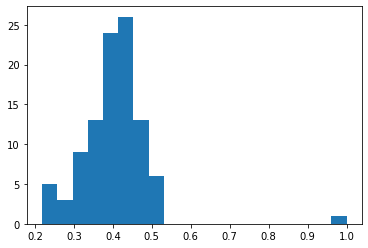

In [12]:
plt.hist(jaccards.values(), 20)
print(sorted(jaccards.values()))
#each annotation set has a weight with jaccard...



In [1]:
#load go2vec
import numpy as np
from keras.models import *
from keras.optimizers import *
from keras.layers import *
from keras.metrics import *
model = print('Load the model..')
modelfile = '../models/GO2vec01_30_2020_17_03_04_069745.h5'
model = load_model(modelfile)


Using TensorFlow backend.
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np

Load the model..


W0209 23:41:53.756806 140416902350208 deprecation_wrapper.py:119] From /home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0209 23:41:54.046002 140416902350208 deprecation_wrapper.py:119] From /home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0209 23:41:54.046983 140416902350208 deprecation_wrapper.py:119] From /home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0209 23:41:54.047813 140416902350208 deprecation_wrapper.py:119] From /home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/keras/backend/tensorflow_back

In [2]:
print(model.layers)
inputlayer = Input((1,) , name='target_in')
layer = model.get_layer('embedding')
x = layer(inputlayer)
embedder = Model( inputs=[inputlayer] , outputs =[x]  )
embedder.build( input_shape = (1,) )
print(embedder.summary())

[<keras.engine.input_layer.InputLayer object at 0x7fb4d8f01780>, <keras.engine.input_layer.InputLayer object at 0x7fb4d8f017f0>, <keras.layers.embeddings.Embedding object at 0x7fb4d8f01c50>, <keras.layers.core.Reshape object at 0x7fb4d8f01dd8>, <keras.layers.core.Reshape object at 0x7fb4d8f01a58>, <keras.layers.merge.Dot object at 0x7fb4d8f01ac8>, <keras.layers.core.Reshape object at 0x7fb4d8f01ba8>, <keras.layers.core.Dense object at 0x7fb4d8f01b00>]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
target_in (InputLayer)       (None, 1)                 0         
_________________________________________________________________
embedding (Embedding)        (None, 1, 5)              108150    
Total params: 108,150
Trainable params: 108,150
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
import pickle
with open( '../models/gafobects.pkl' , 'rb' ) as gafstats:
    nterms , c , index , reverse_index , sampling = pickle.loads(gafstats.read())
    nannot = sum( c.values())
    

In [32]:
print(sum(c.values()))
print(len(index))
min_annot= 50
#index = { t:index[t] for t in index if c[t] > min_annot }
#c = { t:c[t] for t in index }

#nterms = len(index)
print(len(index))
embedmat = embedder.predict( [np.array(list(index.values()) ) ] )
embedmat = embedmat.reshape(len(index),-1)

print(embedmat)
print(embedmat.shape)
from sklearn.neighbors import KDTree as KD
tree = KD( embedmat )
print(tree)

with open('kdtree.pkl' , 'wb') as treeout:
    treeout.write( pickle.dumps(tree))
with open('embedmat.pkl' , 'wb') as treeout:
    treeout.write( pickle.dumps(embedmat))

136560693
31426
31426


NameError: name 'embedder' is not defined

In [26]:

with open('kdtree.pkl' , 'rb') as treeout:
    tree= pickle.loads(treeout.read())
with open('embedmat.pkl' , 'rb') as treeout:
    embedmat = pickle.loads(treeout.read())


In [ ]:
#use the embedder on sets of go terms
govecs ={ r : embedder.predict( np.asarray([ index[go] for go in godict[r] if go in index ]) ) for r in godict }



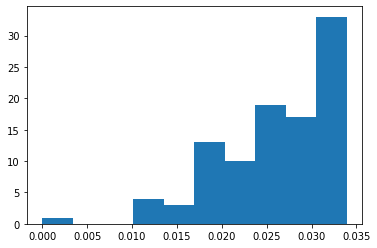

catalytic activity, acting on a tRNA
['trans-hexaprenyltranstransferase activity', 'lipoprotein particle receptor activity', 'regulation of digestive system process', 'nuclear membrane fusion involved in karyogamy', 'negative regulation by organism of entry into cell of other organism via phagocytosis involved in symbiotic interaction', 'response to vitamin K', 'positive regulation of steroid biosynthetic process', 'ferredoxin-nitrate reductase activity', 'intrinsic component of organelle membrane', 'mitotic telomere tethering at nuclear periphery', 'histone H4-R3 demethylation', 'positive regulation of neuron differentiation', 'guanylate cyclase regulator activity', 'L-methionine salvage from methionine sulphoxide', 'N-(5-amino-5-carboxypentanoyl)-L-cysteinyl-D-valine synthase activity', 'Set3 complex', 'positive regulation of RNA interference', 'regulation of Wnt signaling pathway involved in dorsal/ventral axis specification', 'regulation of purine nucleotide biosynthetic process', 

In [16]:

dist, ind = tree.query(  embedmat[ index[go2id('GO:0000010')] ].reshape(1,-1) , k=100)

plt.hist(dist.ravel())
plt.show()

print( obo[ id2GO(int(reverse_index[go2id('GO:0000010')]))].name  )
print([ obo[ id2GO(int(reverse_index[Id]))].name for Id in list(ind[0])  if  id2GO(int(reverse_index[Id])) in obo] )


In [17]:
print(obo['GO:0000002'].name)
go = obo['GO:0000002']
print( get_ancestors([go.id] , obo ) )

mitochondrial genome maintenance
[7005, 16043, 2, 6996, 9987, 71840]


In [ ]:
import random


#print( get_ancestors( [ id2GO(g) for g in godict['479378']], obo) )


for i in range(govecs['479378'].shape[0]):
    print( obo[goa.id2goterm( godict['479378'][i] )])
    dist, ind = tree.query( govecs['479378'][i] , k=50)    
    print('returned terms')
    #print(obo[list(godict['HOG:0479378'])[i]].name)
    print(ind)
    plt.hist(dist.ravel())
    plt.show()
    print([ obo[ id2GO(int(reverse_index[Id]))].name for Id in list(ind[0]) if  id2GO(int(reverse_index[Id])) in obo]  )

    

In [72]:
#free up the gpu
del embedder

In [ ]:
#create a normalized taxonomy embedding for a species aware classifier
print( len ( [ l for l in p.tree.get_leaves() ]))
import time
leaves = [ l for l in p.tree.get_leaves() ]
import random

times =[]
for i in range(100):
    t = time.time()
    p.tree.get_distance(random.choice(leaves).name,random.choice(leaves).name, topology_only=True)
    times.append(time.time()-t)
plt.hist(times)
print( np.mean(times)*(2290**2 / 2 - 2290) / 60 )



In [34]:

import multiprocessing as mp
from functools import partial

pool = mp.Pool()
distances = [ (l1.name,l2.name ) for i,l1 in enumerate(p.tree.get_leaves()) for j,l2 in enumerate(p.tree.get_leaves()) if i < j  ]
indices = [ (i,j )   for i,l1 in enumerate(p.tree.get_leaves()) for j,l2 in enumerate(p.tree.get_leaves()) if i < j  ]

def treedist( ltuple , tree):
    return tree.get_distance( ltuple[0] , ltuple[1], topology_only = True)

nleaves = len([ l for l in p.tree.get_leaves() ] )
treedist_load = partial( treedist , tree= p.tree )
res = pool.map_async(   treedist_load , distances ).get()

del pool

Process ForkPoolWorker-5:
Process ForkPoolWorker-4:
Process ForkPoolWorker-3:
Process ForkPoolWorker-6:
Process ForkPoolWorker-8:
Process ForkPoolWorker-7:
Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  F

KeyboardInterrupt: 

  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [ ]:
taxmat = np.zeros( (nleaves, nleaves) )
for i,index in enumerate(indices):
    taxmat[index] = res[i]
taxmat+=taxmat.T

print(taxmat)
plt.hist(taxmat.ravel())
plt.show()
with open( 'taxkernel.pkl' ,'wb')as taxkernelout:
    taxkernelout.write(pickle.dumps(distances))
#project down with mds

In [ ]:
from sklearn.manifold import MDS
#create taxonomy projection
mds = MDS( n_components = 2 )
taxembed = mds.fit_transform(taxmat)
with open( 'taxproj.pkl' , 'wb') as taxprojout:
    taxprojout.write( pickle.dumps(taxembed))

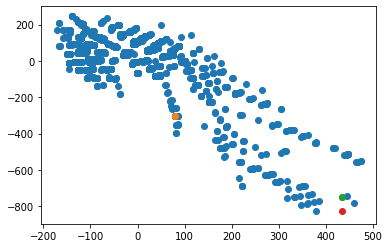

In [35]:
with open( 'taxproj.pkl' , 'rb' ) as taxprojin :
    taxembed = pickle.loads( taxprojin.read())
    
#use the profiler trimmed ncbi tree to generate an index 
taxindex = {int( n.name ) : i for i,n in enumerate( p.tree.get_leaves() ) }

plt.scatter( taxembed[:,0], taxembed[:,1]  )
#where is arabidopsis
plt.scatter( taxembed[taxindex[3702],0] , taxembed[taxindex[3702],1])
#where is human
plt.scatter( taxembed[taxindex[9606],0] , taxembed[taxindex[9606],1])
#where is chimp
plt.scatter( taxembed[taxindex[9606],0] , taxembed[taxindex[9598],1])
plt.show()
#ok... this more or less works


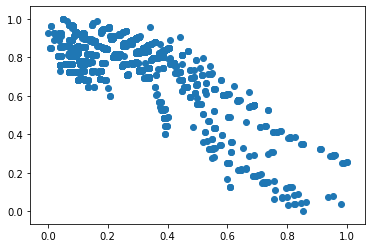

In [36]:
from sklearn.preprocessing import RobustScaler , MinMaxScaler
rs = MinMaxScaler()
taxembedscaled = rs.fit_transform( taxembed )
plt.scatter( taxembedscaled[:,0], taxembedscaled[:,1]  )
plt.show()

In [37]:
embedmat_scaled = rs.fit_transform( embedmat )

In [160]:
from sklearn.cluster import AffinityPropagation
from scipy.stats import rankdata
def profiler_naive( qhog ,  p , gaf , c , nannot , hogs,  k , verbose  , obo , ignoreqhog):
    #use jaccard and IC to weigh all returned GO terms
    res = p.hog_query(fam_id = qhog , k = k )
    if len(res) == 0 :
        return None
    #grab entries from hogs
    hashes =  p.pull_hashes(res+[qhog])
    jaccards = { r:hashes[r].jaccard(hashes[qhog]) for r in res }
    members =  { r : [m for m in hogs[int(r)] if m in gaf ] for r in res  }
    godict = {  m + '_' + str(go) :{ 'fam':r , 'GO':go , 'Jaccard': jaccards[r] } for r in members for m in members[r] for go in get_ancestors( gaf[m] , obo )  }
    godf = pd.DataFrame.from_dict( godict , orient = 'index')
    ICs = { go:-np.log( c[go] / nannot ) for go in godf.GO.unique() if go in c }
    ICs.update( { go:max(ICs.values()) for go in godf.GO.unique() if go not in ICs }  )
    godf['IC'] = godf.GO.map(ICs)
    if ignoreqhog == True:
        godf = godf[ godf.fam != str(qhog) ]
        godf = godf[ godf.fam != qhog ]
    #calculate the jaccards relative to the query
    godf['jaccard'] = godf.fam.map(jaccards)
    #max jaccard * IC
    preddict = {}
    
    preddict= { go:{'max_jaccard':godf[godf.GO == go].jaccard.max() , 'IC':ICs[go] , 'coverage' : len( godf[godf.GO == go ]) / len(godf)  } 
                      for go in godf.GO.unique() if go in ICs and go not in preddict}
    
    if ignoreqhog == False:
            preddict.update( { go:{'max_jaccard':1 , 'IC':10**-3 , 'coverage' : 1  } for go in godf.GO[godf.fam == qhog ].unique() if go in ICs } )
    predDF = pd.DataFrame.from_dict( preddict , orient = 'index')
    #awesome master super scoring function goes here
    predDF['score'] =   (predDF.max_jaccard /  predDF.max_jaccard.max() )  * ( predDF.IC.min() /  predDF.IC ) * (predDF.coverage / predDF.coverage.max())        
    #consequences be damned...
    return predDF

def embedding_kd_ap(qhog,  p, kdtree, embedmat , index , reverse_index , nannot, c , k  , nsuggestions , hogs , obo, ignoreqhog):
    #use kdtree of go term embedding and profiler to grab suggestions
    #centroids of annotation clusters of all hogs returned are used to suggest k terms each
    #each cluster gets a jaccard score.
    #each annotation suggested gets distance from centroid. jaccard and IC
    res = p.hog_query(fam_id = qhog , k = k )
    
    if len(res) == 0 :
        return None
    
    
    #grab entries from hogs leaving qhog in there
    members =  { r : [m for m in hogs[int(r)] if m in gaf ] for r in res  }
    
    godict = {  m + '_' + str(go) :{ 'fam':r , 'GO':go } for r in members for m in members[r] for go in get_ancestors( gaf[m] , obo )  }
    godf = pd.DataFrame.from_dict( godict , orient = 'index')
    
    
    if len(godict) == 0:
        return None
    
    hashes =  p.pull_hashes(res + [qhog])
    jaccards = { r:hashes[r].jaccard(hashes[qhog]) for r in members }
    
    godf['jaccard'] = godf.fam.map(jaccards)
    
    
    if ignoreqhog == True:
        try:
            godf = godf[ godf.fam != qhog ]
            godf = godf[ godf.fam != str(qhog) ]
        except:
            return None
    
    
    #get the terms in embedding space    
    GO_embedding = [ index[go] for go in godf.GO.unique() if go in index ]
    terms = np.array( godf.GO.unique() )
    coverage={  go : len( godf[godf.GO == go ]) / len(godf) for go in godf.GO.unique() }
    godf['coverage'] = godf.GO.map( coverage ) 
    
    govecs = embedmat[GO_embedding,:]
    af = AffinityPropagation().fit(np.vstack( govecs ) )
    #take cluster centroids
    #k suggestions per cluster centroid
    Preds = []
    godf['clusters'] =  godf.GO.map( dict ( zip (godf.GO.unique() ,af.labels_ )) ) 
    #add queries cluster size is a s standin for coverage
    for i, l in enumerate(list(np.unique(af.labels_) )):
        #each label corresponds to a set of annotations in coevolving profiles
        subdf = godf.loc[godf.clusters == l ]
        maxjaccard = subdf.jaccard.mean()
        maxcoverage = subdf.coverage.mean()    
        #mix in initial results
        dis,idx = tree.query( af.cluster_centers_[i].reshape(1, -1) , k= nsuggestions )
        
        Preds.append( { reverse_index[matrow] : {  'jaccard':maxjaccard , 'coverage': maxcoverage , 'distance':max(dis[0][j] , 10**-4) }  for j,matrow in enumerate(list(idx[0])) } )
        #original terms are at distance delta... 
        Preds.append( { term : { 'jaccard':godf[godf.GO == term].jaccard.max() , 'coverage': coverage[term] ,  'distance': 10**-4 }  for  term in list(subdf.GO.unique() ) if term in index }  )
    
    predDF = pd.concat([ pd.DataFrame.from_dict( Pred , orient = 'index' ) for Pred in Preds ])
    
    #del Preds
    
    ICs = { go: -np.log( c[go] / nannot ) for go in predDF.index.unique() if go in c }
    ICs.update( { go:max(ICs.values()) for go in predDF.index.unique() if go not in ICs }  )
    predDF['IC'] = predDF.index.map(ICs)
    
    #awesome super scoring function goes here. maybe give the suggestions a bit less weight
    #predictions farther from the centroid get less weight
    #coev score influences the pred as well
    
    predDF['score'] =  (predDF.jaccard / predDF.jaccard.max()) * (  predDF.IC.min() / predDF.IC )   *  ( predDF.coverage / predDF.coverage.max() ) * ( predDF.distance.min() / predDF.distance ) 
    #predDF['name'] = predDF.index.map(lambda go : obo[ id2GO(go)].name )
    
    predDF = predDF[~predDF.score.isna()]
    
    #consequences be damned...
    
    return predDF

def multiprofiler_embedding_kd_ap(qhog, profilers , kdtree, embedmat , index , reverse_index , nannot, c , k  , nsuggestions , hogs , obo, taxfilters,specdict, ignoreqhog , verbose = True ):
    
    #use kdtree of go term embedding and profiler to grab suggestions
    #centroids of annotation clusters of all hogs returned are used to suggest k terms each
    #each cluster gets a jaccard score.
    #each annotation suggested gets distance from centroid. jaccard and IC
        
    jaccards = {}
    resulthogs = {}
    for ptype in profilers:
        res = profilers[ptype].hog_query(fam_id = qhog , k = k )
        if len( res ) > 0:
            if ignoreqhog == True:
                try:
                    res.remove(str(qhog))
                except:
                    pass
            resulthogs[ptype] = res
            hashes =  profilers[ptype].pull_hashes(res + [qhog])
            jaccards[ptype] = { r:hashes[r].jaccard(hashes[qhog]) for r in res }

    ###begin mp here    
    if len(jaccards) == 0 :
        return None
    #grab k best jaccards over all profilers
    scores = np.hstack([ list(jaccards[ptype].values()) for ptype in jaccards] )
    ranking = np.argsort(-scores )
    counter = 0
    topscores = {}
    for ptype in jaccards.keys():
        for r in jaccards[ptype]:
            if ranking[counter] < k:
                if ptype in topscores:
                    topscores[ptype].append(r)
                else:
                    topscores[ptype]=[r]
            counter +=1
    
    
    members =  { r : [ m for m in hogs[int(r)] if  str(specdict[ m[0:5] ]) in taxfilters[ptype] and m in gaf ] for ptype in topscores for r in topscores[ptype] }
    godict = {  m + '_' + str(go) :{ 'fam':r , 'GO':go } for r in members for m in members[r] for go in get_ancestors( gaf[m] , obo )  }    
    jaccard =  { r :jaccards[ptype][r] for ptype in jaccards for r in jaccards[ptype] }
    godf = pd.DataFrame.from_dict( godict , orient = 'index')
    
    if len(godict) == 0:
        return None
    godf['jaccard'] = godf.fam.map(jaccard)
    if ignoreqhog == True:
        try:
            godf = godf[ godf.fam != qhog ]
            godf = godf[ godf.fam != str(qhog) ]
        except:
            print("err qhog")
    
    #get the terms in embedding space    
    GO_embedding = [ index[go] for go in godf.GO.unique() if go in index ]
    terms = np.array( godf.GO.unique() )
    coverage={  go : len( godf[godf.GO == go ]) / len(godf) for go in godf.GO.unique() }
    godf['coverage'] = godf.GO.map( coverage ) 
    
    govecs = embedmat[GO_embedding,:]
    af = AffinityPropagation().fit(np.vstack( govecs ) )
    #take cluster centroids
    #k suggestions per cluster centroid
    Preds = []
    godf['clusters'] =  godf.GO.map( dict ( zip (godf.GO.unique() ,af.labels_ )) ) 
    #add queries cluster size is a s standin for coverage
    for i, l in enumerate(list(np.unique(af.labels_) )):
        #each label corresponds to a set of annotations in coevolving profiles
        subdf = godf[godf.clusters == l ]
        
        maxjaccard = subdf.jaccard.mean()
        maxcoverage = subdf.coverage.mean()    
        #mix in initial results
        dis,idx = tree.query( af.cluster_centers_[i].reshape(1, -1) , k= nsuggestions )
        Preds.append( { reverse_index[matrow] : {  'jaccard':maxjaccard , 'coverage': maxcoverage , 'distance':max(dis[0][j] , 10**-4) }  for j,matrow in enumerate(list(idx[0])) } )
        #original terms are at distance delta... 
        Preds.append( { term : { 'jaccard':godf[godf.GO == term].jaccard.max() , 'coverage': coverage[term] , 'distance': 10**-4  }  for  term in list(subdf.GO.unique() ) if term in index }  )
    
    
    
    predDF = pd.concat([ pd.DataFrame.from_dict( Pred , orient = 'index' ) for Pred in Preds ])
    
    ICs = { go: -np.log( c[go] / nannot ) for go in predDF.index.unique() if go in c }
    ICs.update( { go:max(ICs.values()) for go in predDF.index.unique() if go not in ICs }  )
    predDF['IC'] = predDF.index.map(ICs)
    
    #awesome super scoring function goes here. maybe give the suggestions a bit less weight
    #predictions farther from the centroid get less weight
    #coev score influences the pred as well
    
    predDF['score'] =  (predDF.jaccard / predDF.jaccard.max()) * (  predDF.IC.min() / predDF.IC )   *  ( predDF.coverage / predDF.coverage.max() ) * ( predDF.distance.min() / predDF.distance ) 
    #predDF['name'] = predDF.index.map(lambda go : obo[ id2GO(go)].name )
    
    predDF = predDF[~predDF.score.isna()]
    
    #consequences be damned...
    
    return predDF




In [165]:
from sklearn.metrics import roc_curve , precision_recall_curve
from functools import partial
import random

nannot = sum(c.values())
nsamples = 100
randoHogs =[ random.choice(list(hogs.keys())) for i in range( nsamples ) ]

         max_jaccard         IC  coverage     score  ytrue
4615        0.000000   0.000000  0.000000  0.000000      1
5975        0.000000   0.000000  0.000000  0.000000      1
16853       0.000000   0.000000  0.000000  0.000000      1
16866       0.000000   0.000000  0.000000  0.000000      1
16868       0.000000   0.000000  0.000000  0.000000      1
166         0.894531   5.011622  0.003344  0.034262      0
2790        0.683594   8.560025  0.003025  0.013869      0
3674        0.945312   5.156561  0.025796  0.271460      1
3676        0.945312   4.558577  0.008599  0.102356      0
3677        0.437500   4.970424  0.004299  0.021723      0
3723        0.726562   5.664284  0.002389  0.017587      0
3735        0.460938   6.575424  0.004618  0.018582      0
3824        0.742188   3.846636  0.010350  0.114636      1
4175        0.742188   6.669506  0.003344  0.021361      0
4190        0.742188   8.684129  0.003344  0.016405      0
4518        0.437500   6.913312  0.000159  0.000578     

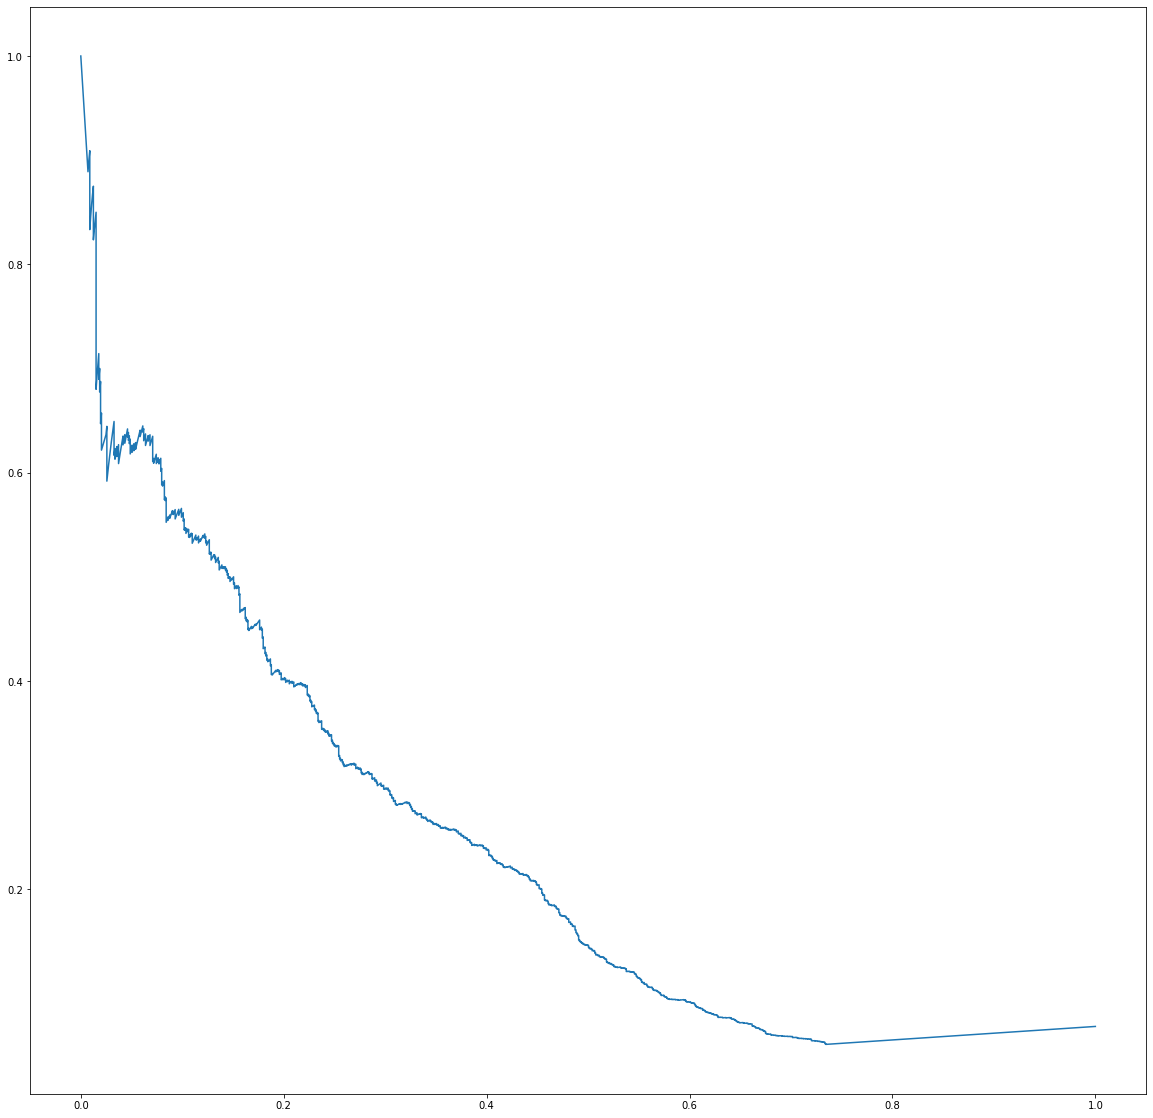

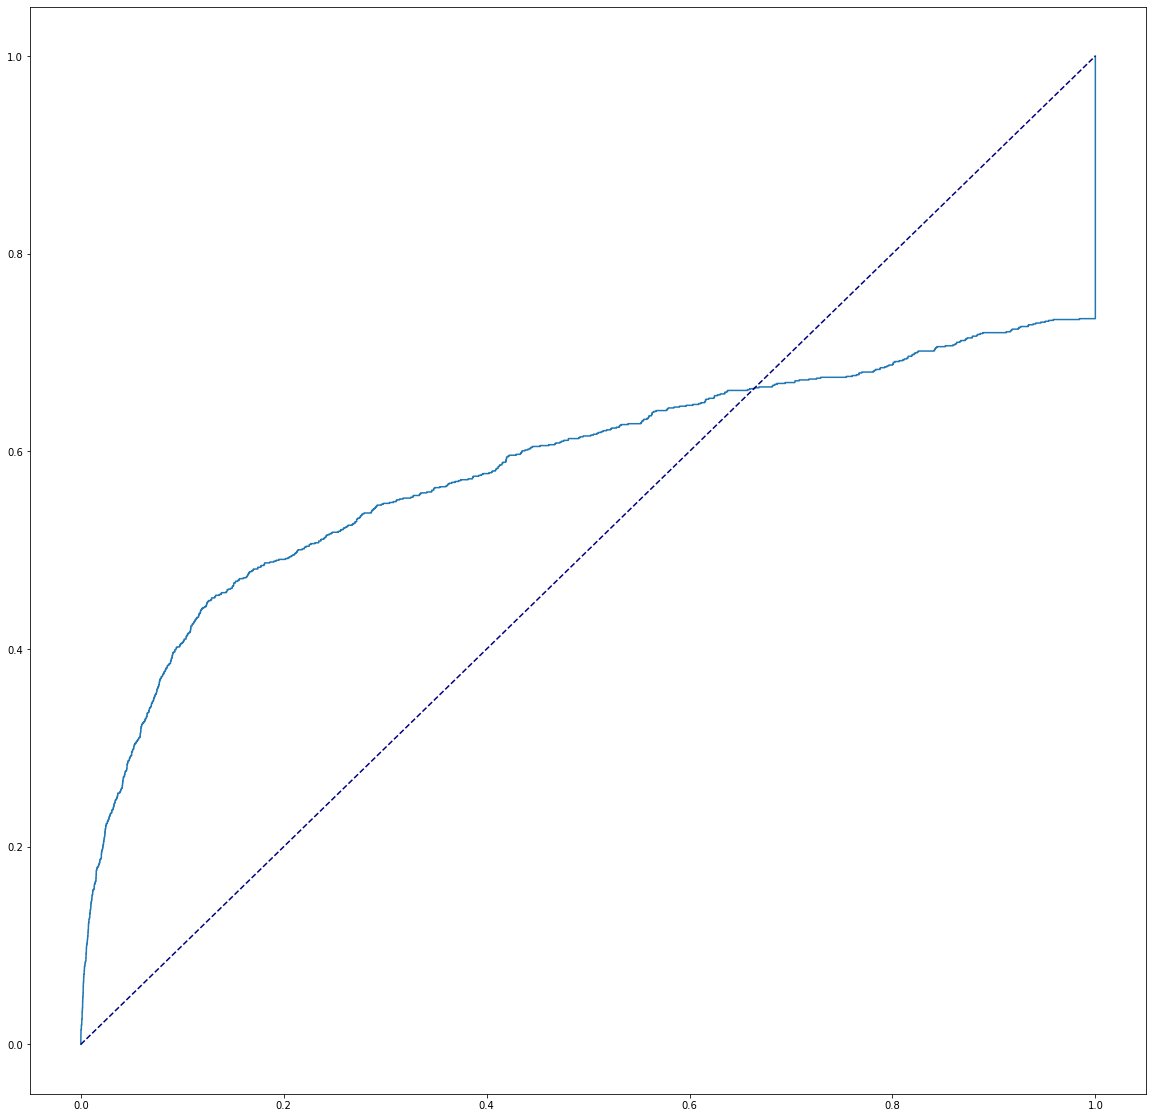

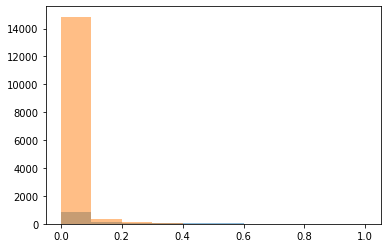

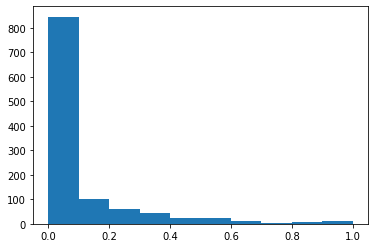

          jaccard  coverage  distance         IC     score  ytrue
4615     0.000000  0.000000  0.000000   0.000000  0.000000      1
5975     0.000000  0.000000  0.000000   0.000000  0.000000      1
16866    0.000000  0.000000  0.000000   0.000000  0.000000      1
16868    0.000000  0.000000  0.000000   0.000000  0.000000      1
3677     0.604828  0.007867  0.654222   4.970424  0.000008      0
4519     0.604828  0.007867  1.147651   7.279508  0.000003      0
6259     0.604828  0.007867  1.303655   6.185757  0.000003      0
6810     0.604828  0.007867  1.058771   5.312720  0.000005      0
8643     0.604828  0.007867  1.625822   7.358536  0.000002      0
9405     0.604828  0.007867  1.216452   8.322366  0.000003      0
15291    0.604828  0.007867  1.782954   7.508117  0.000002      0
16887    0.604828  0.007867  1.709895   6.519236  0.000002      0
17111    0.604828  0.007867  1.512353   6.028123  0.000003      0
22857    0.604828  0.007867  1.550558   6.353675  0.000003      0
31226    0

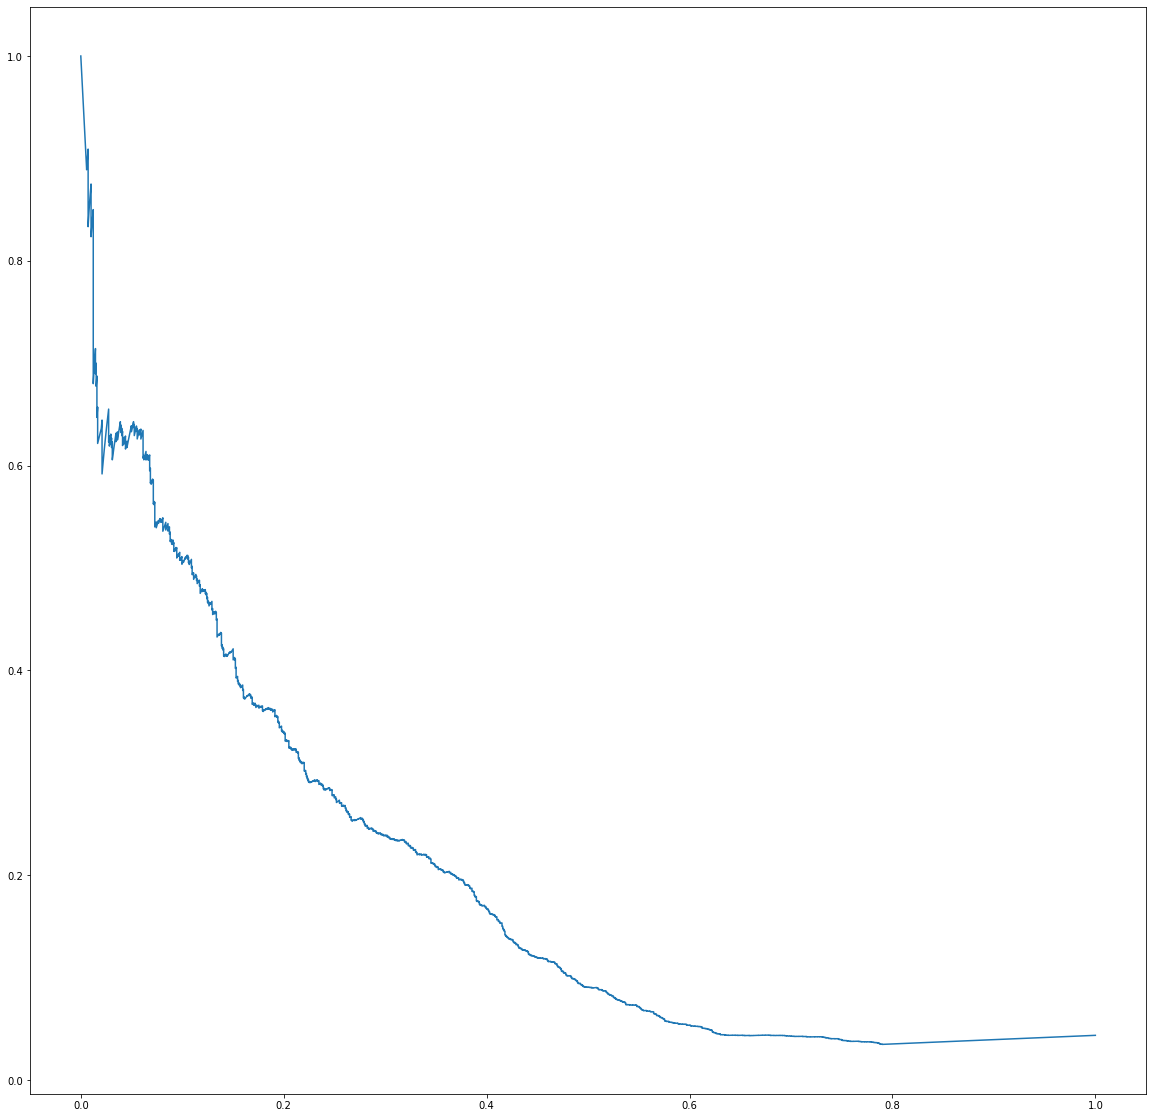

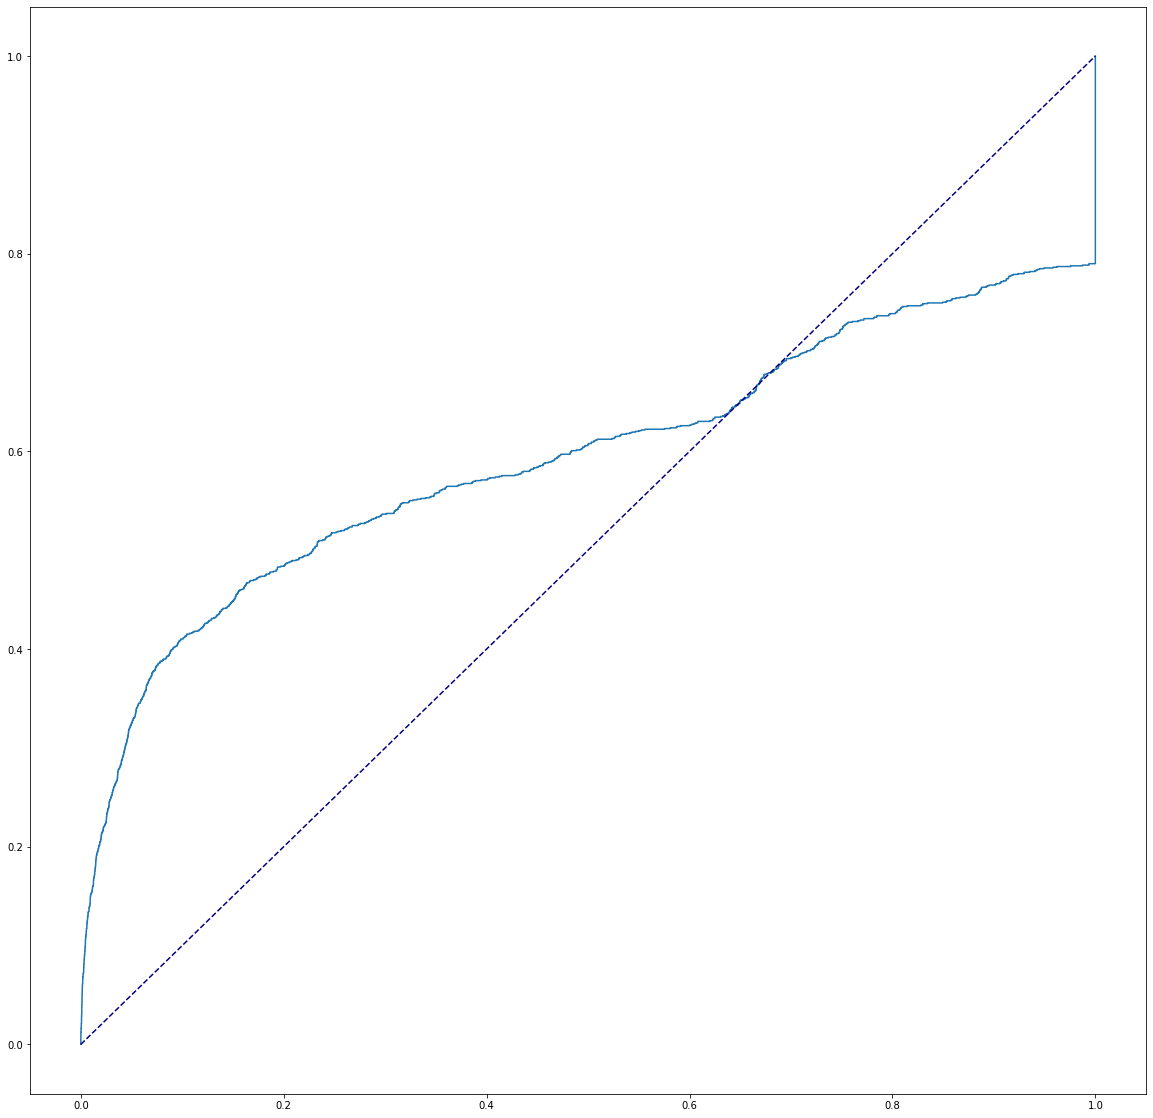

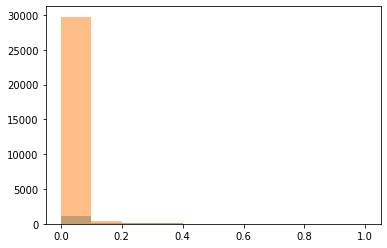

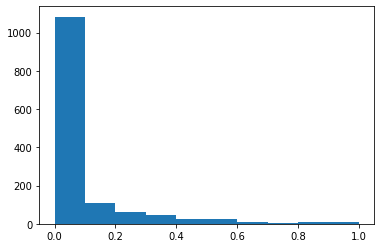

          jaccard  coverage  distance         IC     score  ytrue
4615     0.000000  0.000000  0.000000   0.000000  0.000000      1
16853    0.000000  0.000000  0.000000   0.000000  0.000000      1
16866    0.000000  0.000000  0.000000   0.000000  0.000000      1
16868    0.000000  0.000000  0.000000   0.000000  0.000000      1
8961     0.460938  0.013876  3.758548  11.154646  0.000002      0
9144     0.460938  0.013876  3.507266  11.245106  0.000002      0
9210     0.460938  0.013876  3.794842  11.923240  0.000002      0
9288     0.460938  0.013876  1.188530   8.990547  0.000007      0
9424     0.460938  0.013876  2.903598   9.894308  0.000003      0
9425     0.460938  0.013876  2.007940   9.073990  0.000004      0
9992     0.460938  0.013876  3.206551  11.531855  0.000002      0
35529    0.460938  0.013876  3.806581  10.047033  0.000002      0
36220    0.460938  0.013876  3.771902  11.316503  0.000002      0
42995    0.460938  0.013876  1.691528   8.174542  0.000005      0
43228    0

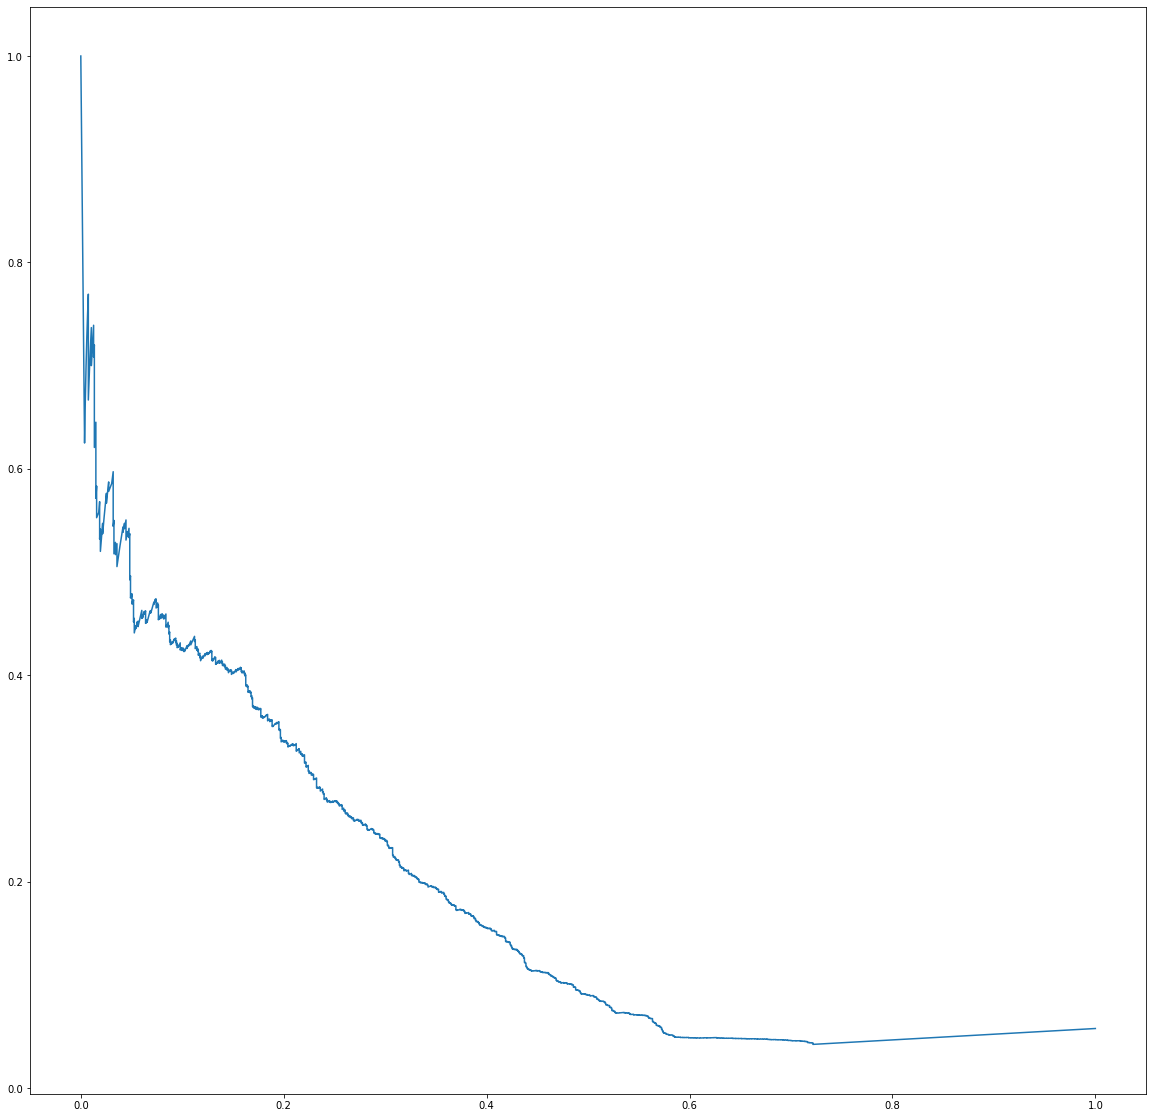

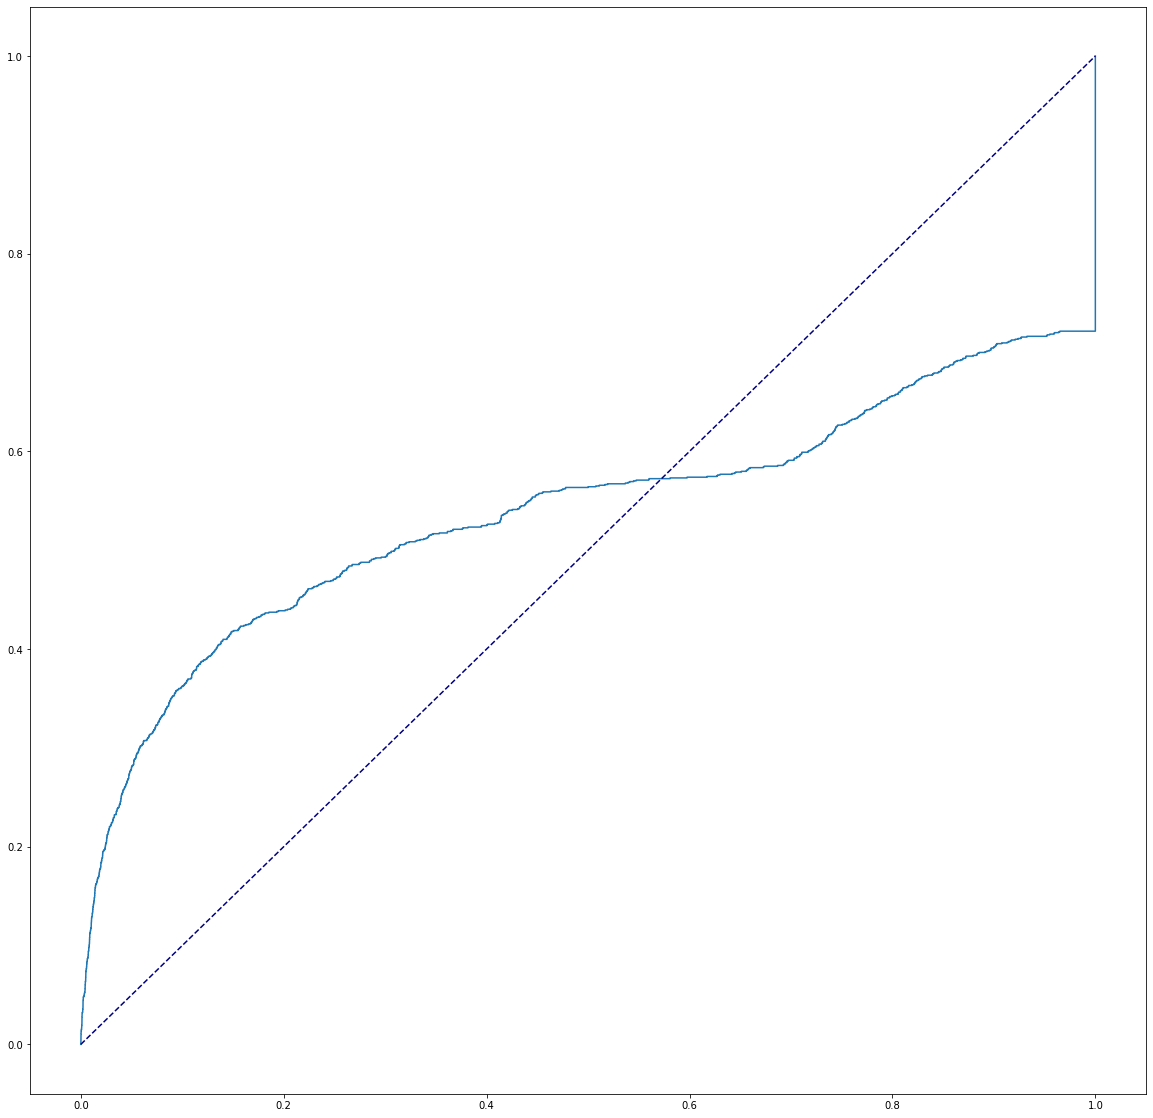

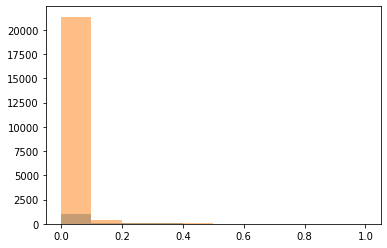

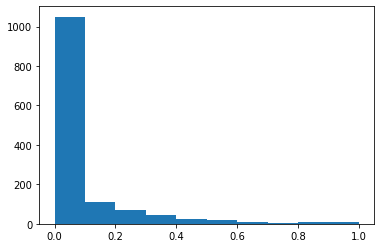

In [166]:
from multiprocessing import Manager
import multiprocessing as mp
import time

def prec_recall( randoHogs, profilerfun_partial , gaf , obo ):
    dfs = []
    t0 = time.time()    
    for h in randoHogs:
        predDF = profilerfun_partial(h)
        
        if predDF is not None:
            goset =  { go   for m in { m for m in hogs[int(h)]  if m in gaf } for go in get_ancestors( gaf[m] , obo )  }
            remainder = goset.difference( set(predDF.index ))
            remainderDF = pd.DataFrame.from_dict({ r : { c:0 for c in predDF.columns } for r in remainder} , orient = 'index')
            predDF = pd.concat([remainderDF,predDF])
            predDF['ytrue'] = predDF.index.map( lambda x : 1 if x in goset else 0 )
            dfs.append(predDF)
    finaldf = pd.concat(dfs)
    print(finaldf)
    precision, recall, thresholds = precision_recall_curve(finaldf.ytrue, finaldf.score)
    
    plt.figure( figsize = (20,20))
    plt.plot( recall , precision )
    plt.show()
    
    fpr, tpr, thresholds = roc_curve( finaldf.ytrue, finaldf.score )
    plt.figure( figsize = (20,20))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
    plt.show()
    
    plt.hist( finaldf.score[finaldf.ytrue == 1] , alpha = .5)
    plt.hist( finaldf.score[finaldf.ytrue == 0] , alpha = .5)
    plt.show()
    plt.hist( finaldf.score[finaldf.ytrue == 1] )
    plt.show()
    
    return finaldf


k = 20
nsuggestions = 15
ignoreqhog = True
verbose = True
profiler_naive_conf = partial(profiler_naive ,   p=profilers['all'] , gaf=gaf , c=c , nannot=nannot , hogs=hogs ,  k=30  , verbose=False  , obo = obo, ignoreqhog=True )
embedder_profiler = partial(embedding_kd_ap  ,  p=profilers['all'] , kdtree = tree, embedmat=embedmat , index=index , reverse_index=reverse_index , nannot=nannot, c=c , k=30  , nsuggestions=15 , hogs=hogs , obo= obo,  ignoreqhog= True )
multiprof_conf = partial(multiprofiler_embedding_kd_ap  , profilers = profilers , kdtree = tree, embedmat=embedmat , index=index , reverse_index=reverse_index , nannot=nannot, c=c , k=30  , nsuggestions=15 , hogs=hogs , obo = obo, taxfilters = taxfilters, specdict = specdict, ignoreqhog= True )

finaldf_naive = prec_recall( randoHogs , profiler_naive_conf , gaf , obo )
#
finaldf_embedder = prec_recall( randoHogs , embedder_profiler , gaf , obo )
finaldf_multi = prec_recall( randoHogs , multiprof_conf , gaf , obo )        

0.1486807237661268
0.20593355442443592


/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


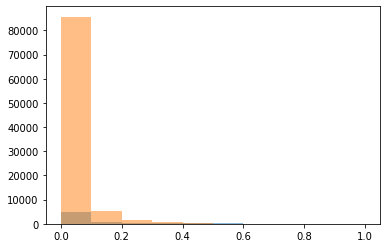

In [92]:
#todo. fit distribution to positive scores
from scipy.stats import norm
#just model the stupid things as multivariat gaussians and get a pval for each pred
filterfinal_naive = finaldf_naive[finaldf_naive.score > 0]
filterfinal_naive =  filterfinal_naive[ filterfinal_naive.ytrue == 1 ]
naive_mean_posi = filterfinal_naive.score.mean()
naive_std_posi = filterfinal_naive.score.std()
print(naive_mean_posi)
print(naive_std_posi)
finaldf_naive['proba_posi'] =  norm.cdf( finaldf_naive.score , loc=naive_mean_posi, scale= naive_std_posi )
finaldf_naive['proba_posi'][finaldf_naive.score == 0 ] = 0 

filterfinal_embedder= finaldf_embedder[finaldf_embedder.score > 0]
filterfinal_embedder=filterfinal_embedder[ filterfinal_embedder.ytrue == 1  ]
embedder_mean_posi = filterfinal_embedder.score.mean()
embedder_std_posi = filterfinal_embedder.score.std()
finaldf_embedder['proba_posi'] =  norm.cdf( finaldf_embedder.score , loc=embedder_mean_posi, scale= embedder_std_posi )

filterfinal_multi= finaldf_multi[finaldf_multi.score > 0]
filterfinal_multi=filterfinal_embedder[ filterfinal_embedder.ytrue == 1  ]
multi_mean_posi = filterfinal_embedder.score.mean()
multi_std_posi = filterfinal_embedder.score.std()
finaldf_multi['proba_posi'] =  norm.cdf( finaldf_embedder.score , loc=embedder_mean_posi, scale= embedder_std_posi )

plt.hist( finaldf_embedder.score[finaldf_embedder.ytrue == 1] , alpha =.5 )
plt.hist( finaldf_embedder.score[finaldf_embedder.ytrue == 0]  , alpha =.5)
plt.show()

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


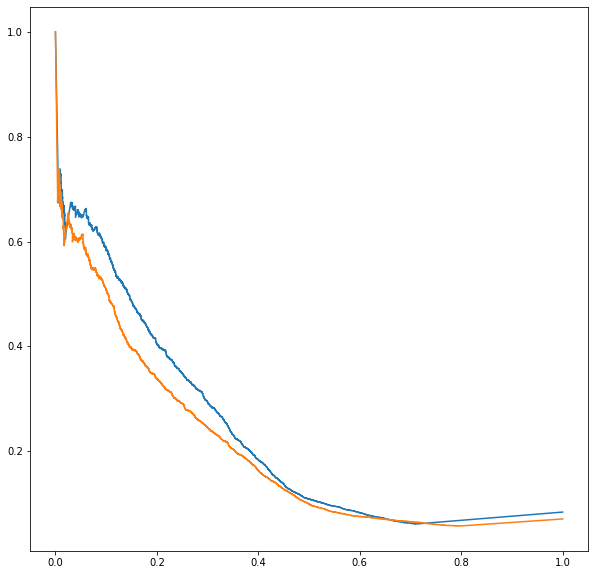

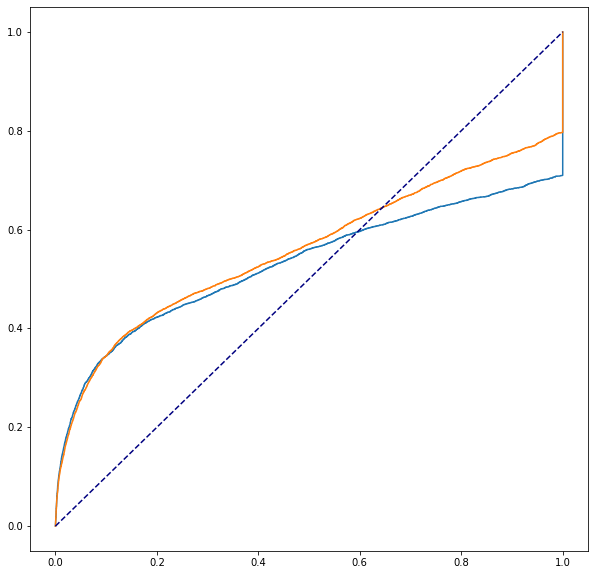

In [93]:
finaldf_naive.proba_posi[finaldf_naive.score == 0 ] = 0
finaldf_embedder.proba_posi[finaldf_embedder.score == 0 ] = 0
plt.figure( figsize = (10,10))
precision, recall, thresholds = precision_recall_curve(finaldf_naive.ytrue, finaldf_naive.proba_posi)
plt.plot(   recall , precision )

precision, recall, thresholds = precision_recall_curve(finaldf_embedder.ytrue, finaldf_embedder.proba_posi)
plt.plot(   recall , precision )


precision, recall, thresholds = precision_recall_curve(finaldf_multi.ytrue, finaldf_multi.proba_posi)
plt.plot(   recall , precision )

plt.show()

plt.figure( figsize = (10,10))
fpr, tpr, thresholds = roc_curve( finaldf_naive.ytrue, finaldf_naive.proba_posi )
plt.plot(fpr ,tpr)
fpr, tpr, thresholds = roc_curve( finaldf_embedder.ytrue, finaldf_embedder.proba_posi)
plt.plot(fpr ,tpr)

fpr, tpr, thresholds = roc_curve( finaldf_multi.ytrue, finaldf_multi.proba_posi)
plt.plot(fpr ,tpr)



plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.show()

In [87]:
print(len(targets.fam.unique()) )

27235


In [127]:
pip install progress

  Stored in directory: /home/cactuskid13/.cache/pip/wheels/6c/c8/80/32a294e3041f006c661838c05a411c7b7ffc60ff939d14e116
Successfully built progress
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#print(targets)
import math
import datetime
import logging
logging.basicConfig(filename='chunklog.log',level=logging.DEBUG)
from progress.bar import Bar

header1 = """
AUTHOR David Moi
MODEL 1 
KEYWORDS Coevolution , IC

"""

header2 = """
AUTHOR David Moi
MODEL 2 
KEYWORDS Coevolution, IC , GO embedding

"""

chunksize = 1000
chunks =  int( math.ceil( len(targets.fam.unique())/1000 ) )
stamp = datetime.datetime.now().strftime('%m_%d_%Y_%H_%M_%S_%f')
queries = list( targets.fam.unique() )

with open( stamp + 'model1.txt' , 'w')as pred1 :
    #with open(stamp + 'model2.txt'  , 'w') as pred2:
    for i in range(chunks):
        if i == 0 :
            pred1.write(header1)
            #pred2.write(header2)
        print('chunk')
        print(i / chunks)
        #predict for chunk of hogs
        chunk =  queries[i*chunksize: i*chunksize + chunksize]
        for j,qhog in enumerate(chunk):
            predchunk_naive = profiler_naive( qhog , p= p , gaf=gaf , c=c , nannot=nannot , hogs=hogs,  k = 20 , verbose = False , ignoreqhog = False )
            #predchunk_embed =  embedding_kd_ap(qhog,  p = p , kdtree  =tree, embedmat=embedmat , index=index , reverse_index=reverse_index , nannot=nannot, c=c , k = 20  , nsuggestions=15 , hogs=hogs , ignoreqhog = False)
            #predchunk_embed['termstring'] = predchunk_embed.index.map(id2GO)
            predchunk_naive['termstring'] = predchunk_naive.index.map(id2GO)
            
            #finish output pred
            predchunk_naive['proba_posi'] =  norm.cdf( predchunk_naive.score , loc=naive_mean_posi ,  scale=naive_std_posi  )
            print(j)
            
            #predchunk_embed.round(2)
            predchunk_naive.round(2)
            if predchunk_naive is not None:
                #grab all targets for each hog
                subtarget = targets[targets.fam == qhog ]

                for cafa_id in subtarget.cafa_id.unique():
                    #output csv for all targets in chunk
                    for ix,row in predchunk_naive.iterrows():
                        pred1.write( cafa_id + '\t' + row.termstring + '\t' + str(row.proba_posi) + '\n')
                #for row in predchunk_embed.iter_rows():
                    #pred2.write( cafa_id + '/t' +row.termstring + '/t' +  + row.proba_posi )
        logging.info('chunk:' + str(i))


#chunk target rows and save outputs

#create csv 

chunk
0.0
0
1
2
3
4
5
6
7
8


In [165]:
###### start machine learning profiler based function prediction here #####
#fit distribution params to jaccards and annot vecs?
#pull in terms in the embedding and use them as suggestions

def train_gengovec( qseqdfs , p ,  gaf , c , taxembed , embedmat , index  , taxindex , specdict , hogs, visdist  , k , obo,  batchsize ):
    #this is to generate the training data... some info on each go term relative to the profiles pulled in 
    #classifier decides y or n
    nannot = sum(c.values())
    #prob a good idea to generate a bunch of these and fit a normalizer on the data.
    #qseqdata is a generator of dataframes with columns = [ qseq , qhog ]
    #sequences are ordered by Hog number to avoid splitting them up
    govecs =[]
    ys=[]
    for qseqdata in qseqdfs:
        for hog in qseqdata.hog.unique():
            #proceed by hog
            #use the profiler to get all coev HOGs
            res = p.hog_query(hog_id = hog , k = k )
            res+= [str(hog)]
            hashes =  p.pull_hashes(res)
            #get all hog members and annotations
            members =  { r : [ m for m in hogs[int(r)] if m in gaf ] for r in res  }
            globalgodict = {  m + '_' + str(go) :{ 'fam':r , 'omaid':m ,  'GO':go , 'Tax':taxindex[specdict[m[0:5]]] , 'omaid':m } for r in res for m in members[r] for go in get_ancestors( gaf[m] , obo )  }
            if len(globalgodict)>0:
                #embed go and tax
                ggodf = pd.DataFrame.from_dict( globalgodict , orient = 'index')
                ggodf['name'] = ggodf.GO.map(lambda go : obo[ id2GO(go)].name )
                GO_embedding = { go:embedmat[ index[go], : ] for go in ggodf.GO.unique()  if go in index }
                Tax_embedding = { genome:taxembed[genome,:] for genome in ggodf.Tax.unique() }
                ICs = { go:np.log( nannot/c[go]) for go in ggodf.GO.unique()  if go in c }
                ICs.update( { go:max(ICs.values()) for go in ggodf.GO.unique() if go not in ICs }  )

                ggodf['GOembed'] = ggodf.GO.map(GO_embedding)
                ggodf['TaxEmbed'] = ggodf.Tax.map( Tax_embedding )
                ggodf['IC'] = ggodf.GO.map(ICs)
                
                for qhog in ggodf.fam.unique():
                    t0 = time.time()
                    godf = ggodf[ggodf.fam != qhog].copy()
                    godf = godf[ godf.fam != str(qhog) ]
                    
                    
                    if len(godf)>0:
                        #jaccard relative to qhog
                        qHOGgo =  [ embedmat[ index[go] ,:]  for m in ggodf[ggodf.fam == qhog].omaid for go in gaf[m] if go in index]
                        
                        if len(qHOGgo) == 0 :
                            #if no annotations then just use 'biological process' as annotation
                            qHOGavg = embedmat[ index[8150] ,: ]
                            qHOGstdv = [0,0,0]
                        else:
                            qHOGavg = np.mean( np.vstack(qHOGgo))
                            qHOGstdv = np.std( np.vstack(qHOGgo))
                        
                        counts = { go:len(godf[godf.GO==go]) for go in godf.GO.unique() }
                        Freqs = { go:counts[go]/len(godf) for go in godf.GO.unique() }
                        jaccards = { r:hashes[r].jaccard(hashes[qhog]) for r in godf.fam.unique() }
                        godf['jaccard'] = godf.fam.map(jaccards)
                        embedmat_matches = np.vstack(godf.GOembed[ ~godf.GOembed.isna() ])                        
                        GOembedavg = np.mean( embedmat_matches )
                        GOembedstd = np.std( embedmat_matches )
                        ICavg = np.mean( godf.IC )
                        ICstdv = np.std( godf.IC )
                        
                        if visdist:
                            plt.title('Jaccard')
                            plt.hist(godf.jaccard)
                            plt.show()
                            plt.title('IC')
                            plt.hist(list(ICs.values()))
                            plt.show()
                        
                        for go in godf.GO.unique():
                            sub = godf[ godf.GO == go ]
                            taxspread = np.std(np.vstack(sub.Tax))
                            taxcentroid = np.mean(np.vstack(sub.Tax))
                            if visdist:
                                plt.title( 'taxspread:'+  id2GO(go))
                                plt.scatter( taxembed[:,0], taxembed[:,1]  , alpha = .25 )
                                taxa = np.vstack(sub.TaxEmbed)
                                plt.scatter( taxa[:,0], taxa[:,1]  , alpha = 0.25)
                                plt.show()
                            
                            for seq in list(ggodf[ggodf.fam == qhog ].omaid.unique())[0:1000]:
                                #for each go for each qseq in qhog
                                seqTaxEmbed = taxembed[ taxindex[specdict[seq[0:5]]] , :  ]
                                #min taxonomic distance at which the annotation being tested is found
                                taxdists = np.vstack(sub.TaxEmbed.map( lambda x: np.linalg.norm(x-seqTaxEmbed)))
                                if visdist:
                                    plt.title('taxdist')
                                    plt.hist(taxdists)
                                    plt.show()
                                
                                taxdifference = np.vstack(sub.TaxEmbed.map( lambda x: x-seqTaxEmbed) )
                                taxdifferencespread = np.std(np.vstack(taxdifference))
                                taxdifferencecentroid = np.mean(np.vstack(taxdifference))
                                
                                if go in GO_embedding:
                                    govec = np.array( [ sub.IC.max() ,  ICavg , ICstdv , len(godf) , len(sub) ,  
                                                       sub.jaccard.max(),  sub.jaccard.mean() , 
                                                       sub.jaccard.std(), sub.jaccard.max(), sub.jaccard.min() , 
                                                       godf.jaccard.mean() , godf.jaccard.std(), godf.jaccard.max(), 
                                                       godf.jaccard.min(), np.amin(taxdists)  
                                                       ])

                                    govec = np.hstack([govec, seqTaxEmbed , GOembedavg , GOembedstd , GO_embedding[go] , qHOGavg, qHOGstdv , taxspread, taxcentroid , taxdifferencespread , taxdifferencecentroid])

                                    #does the prot have this annotation?
                                    
                                    if go in list(ggodf.GO[ ggodf.fam == str(qhog) ] ):

                                        y = [1]
                                    else:
                                        y =[0]
                                    govecs.append(govec)
                                    ys.append(y)

                                    if len(govecs)>batchsize:
                                        yield ( {'govec':np.vstack(govecs)} , {'y':np.vstack(ys)} )
                                        govecs = []
                                        ys=[]

                                    
#todo write a vec generator for targets and testing
def predict_targets( qhogs , p ,  gaf , c , taxembed , embedmat , index  , taxindex , specdict , hogs, k = 10 ,   visdist = False , obo = obo, batchsize = 100 ):
    nannot = sum(c.values())
    #prob a good idea to generate a bunch of these and fit a normalizer on the data.
    #qseqdata is a generator of dataframes with columns = [ qseq , qhog ]
    #sequences are ordered by Hog number to avoid splitting them up
    govecs =[]
    
    
    for qseqdata in qseqdfs:
        for hog in qseqdata.hog.unique():
            #proceed by hog
            #use the profiler to get all coev HOGs
            res = p.hog_query(hog_id = hog , k = k )
            res+= [str(hog)]
            hashes =  p.pull_hashes(res)
            #get all hog members and annotations
            members =  { r : [ m for m in hogs[int(r)] if m in gaf ] for r in res  }
            globalgodict = {  m + '_' + str(go) :{ 'fam':r , 'omaid':m ,  'GO':go , 'Tax':taxindex[specdict[m[0:5]]] , 'omaid':m } for r in res for m in members[r] for go in get_ancestors( gaf[m] , obo )  }
            if len(globalgodict)>0:
                #embed go and tax
                ggodf = pd.DataFrame.from_dict( globalgodict , orient = 'index')
                ggodf['name'] = ggodf.GO.map(lambda go : obo[ id2GO(go)].name )
                GO_embedding = { go:embedmat[ index[go], : ] for go in ggodf.GO.unique()  if go in index }
                Tax_embedding = { genome:taxembed[genome,:] for genome in ggodf.Tax.unique() }
                ICs = { go:np.log(c[go]/nannot) for go in ggodf.GO.unique()  if go in c }
                
                ggodf['GOembed'] = ggodf.GO.map(GO_embedding)
                ggodf['TaxEmbed'] = ggodf.Tax.map( Tax_embedding )
                ggodf['IC'] = ggodf.GO.map(ICs)
                if len(godf)>0:
                    #jaccard relative to qhog
                    qHOGgo =  [ embedmat[ index[go] ,:]  for m in ggodf[ggodf.fam == qhog].omaid for go in gaf[m] if go in index]

                    if len(qHOGgo) == 0 :
                        #if no annotations then just use 'biological process' as annotation
                        qHOGavg = embedmat[ index[8150] ,: ]
                        qHOGstdv = [0,0,0]
                    else:
                        qHOGavg = np.mean( np.vstack(qHOGgo))
                        qHOGstdv = np.std( np.vstack(qHOGgo))

                    counts = { go:len(godf[godf.GO==go]) for go in godf.GO.unique() }
                    Freqs = { go:counts[go]/len(godf) for go in godf.GO.unique() }
                    jaccards = { r:hashes[r].jaccard(hashes[qhog]) for r in godf.fam.unique() }
                    godf['jaccard'] = godf.fam.map(jaccards)
                    embedmat_matches = np.vstack(godf.GOembed[ ~godf.GOembed.isna() ])                        
                    GOembedavg = np.mean( embedmat_matches )
                    GOembedstd = np.std( embedmat_matches )
                    ICavg = np.mean( godf.IC )
                    ICstdv = np.std( godf.IC )

                    if visdist:
                        plt.title('Jaccard')
                        plt.hist(godf.jaccard)
                        plt.show()
                        plt.title('IC')
                        plt.hist(list(ICs.values()))
                        plt.show()

                    for go in godf.GO.unique():
                        sub = godf[ godf.GO == go ]
                        taxspread = np.std(np.vstack(sub.Tax))
                        taxcentroid = np.mean(np.vstack(sub.Tax))
                        if visdist:
                            plt.title( 'taxspread:'+  id2GO(go))
                            plt.scatter( taxembed[:,0], taxembed[:,1]  , alpha = .25 )
                            taxa = np.vstack(sub.TaxEmbed)
                            plt.scatter( taxa[:,0], taxa[:,1]  , alpha = 0.25)
                            plt.show()
                        for seq in godf[godf.fam == str(qhog) ].omaid.unique():
                            #for each go for each qseq in qhog
                            seqTaxEmbed = taxembed[ taxindex[specdict[seq[0:5]]] , :  ]
                            #min taxonomic distance at which the annotation being tested is found
                            taxdists = np.vstack(sub.TaxEmbed.map( lambda x: np.linalg.norm(x-seqTaxEmbed)))
                            if visdist:
                                plt.title('taxdist')
                                plt.hist(taxdists)
                                plt.show()
                            taxdifference = np.vstack(sub.TaxEmbed.map( lambda x: x-seqTaxEmbed) )
                            taxdifferencespread = np.std(np.vstack(taxdifference))
                            taxdifferencecentroid = np.mean(np.vstack(taxdifference))
                            if go in GO_embedding:
                                govec = np.array( [ sub.IC.max() ,  ICavg , ICstdv , len(godf) , len(sub) ,  
                                                   sub.jaccard.max(),  sub.jaccard.mean() , 
                                                   sub.jaccard.std(), sub.jaccard.max(), sub.jaccard.min() , 
                                                   godf.jaccard.mean() , godf.jaccard.std(), godf.jaccard.max(), 
                                                   godf.jaccard.min(), np.amin(taxdists)  
                                                   ])

                                govec = np.hstack([govec, seqTaxEmbed , GOembedavg , GOembedstd , GO_embedding[go] , qHOGavg, qHOGstdv , taxspread, taxcentroid , taxdifferencespread , taxdifferencecentroid])
                                govecs.append(govec)

                                if len(govecs)>batchsize:
                                    #return vec of GO term
                                    yield ( {'govec':np.vstack(govecs)}  )
                                    

                    

In [166]:

train_govecs = train_gengovec( hogiterator,  p ,  gaf , c , taxembedscaled , embedmat_scaled , index  , taxindex , specdict , hogs, k = 20 ,   visdist = False , obo = obo, batchsize = 100  )

In [183]:
#use this net for predicting binary yes or no for each go term in a set given a set of inputs
import numpy as np
from keras.optimizers import *
from keras.layers import *
from keras.callbacks import *
from keras.models import load_model
import datetime
import keras
global max_epochs
from keras.models import Model
from keras.layers import Flatten, Input, Dense

from keras.backend import tensorflow_backend as K
epsilon = K.epsilon()
stamp = datetime.datetime.now().strftime('%m_%d_%Y_%H_%M_%S_%f')

import tensorflow as tf

################################################################################
dirlocal = './'
dataset = 'full' # 'sample' or 'full'

modelfile = 'model-' + str(stamp) + '.h5'

densedim = 10
layers = 2

govec_test = next( train_govecs )
print( govec_test)

({'govec': array([[ 8.56623560e+00,  6.69238542e+00,  2.82083895e+00, ...,
         2.17407143e+03,  5.28861847e-02, -5.94220393e-03],
       [ 7.40622614e+00,  6.69238542e+00,  2.82083895e+00, ...,
         2.17407143e+03,  5.28917166e-02, -5.92735091e-03],
       [ 7.40622614e+00,  6.69238542e+00,  2.82083895e+00, ...,
         2.17407143e+03,  2.73025128e-02, -3.64634723e-03],
       ...,
       [ 5.31832043e+00,  6.69238542e+00,  2.82083895e+00, ...,
         2.17443750e+03,  5.08229333e-02, -5.45536337e-03],
       [ 4.44678677e+00,  6.69238542e+00,  2.82083895e+00, ...,
         2.17346154e+03,  5.48618092e-02, -6.38330098e-03],
       [ 4.44678677e+00,  6.69238542e+00,  2.82083895e+00, ...,
         2.17346154e+03,  2.67460069e-02, -4.10229730e-03]])}, {'y': array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [

In [ ]:

a = Input(shape= ( govec_test[0]['govec'].shape[1] , )   , name='govec' ) 
#perceptron...
for i in range( layers):
    if i == 0:
        b = Dense(densedim  )(a)
        #layer = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones')
        #b = layer(b)
    else:
        
        b = Dense(densedim )(b)
        layer = BatchNormalization(axis=0, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones')
        #b = layer(b)

#layer = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones')
#final softmax
layer = Dense( 1, activation = 'sigmoid' , name = 'y')
final = layer(b)

#layer = Dense(1,activation = 'sigmoid' , name = 'y')
#final = layer(b)

model = Model(inputs=a, outputs=final)

o = keras.optimizers.RMSprop(lr=.0000001, rho=0.09)
#o = keras.optimizers.Adadelta(lr=.050, rho=0.95)
#o =  keras.optimizers.SGD(lr=0.1, momentum=0.001, nesterov=False)

model.compile( optimizer=o, loss= 'mean_squared_error' , metrics=['accuracy'])
max_len = 3000
mc = ModelCheckpoint(modelfile, monitor = 'loss', mode = 'auto', verbose = 1, save_best_only = False)
lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience= 10 , min_lr=0.00001)
es = EarlyStopping(monitor = 'loss', mode = 'min', verbose = 2, patience = 100)
####change this
history = model.fit_generator( train_govecs  ,verbose = 1 , steps_per_epoch= 1000 , epochs = 100000 , callbacks=[es, lr])